# Hospital readmissions notebook

AI provides clinicians and care managers with the information they need to nurture strong, lasting connections with the patients they care about. AI helps reduce readmission rates by predicting which patients are at risk and allowing clinicians to prescribe intervention strategies before and after the patient is discharged. Unlike existing methods, AI models can ingest significant amounts of data and learn complex patterns behind why certain patients are likely to readmit. With advancements in model interpretability, AI offers personalized explanations for all its predictions, giving clinicians complete transparency of the top risk drivers for every single patient at any given time.

By taking the form of an artificial clinician and augmenting the care they provide, along with other actions clinicians already take, AI enables them to conduct intelligent interventions to improve patient health. Using the information they learn from AI, clinicians can decrease the likelihood of patient readmission by carefully walking through their discharge paperwork in-person, scheduling additional outpatient appointments (to give them more confidence about their health), and providing additional interventions that help reduce readmissions.

For more information about DataRobot's Python client, reference the [documentation](https://datarobot-public-api-client.readthedocs-hosted.com/en/latest/).

## Setup

### Import libraries

In [2]:
import datarobot as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

light_blue = "#598fd6"
grey_blue = "#5f728b"
orange = "#dd6b3d"

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [ ]:
# If the config file is not in the default location described in the API Quickstart guide, '~/.config/datarobot/drconfig.yaml', then you will need to call
# dr.Client(config_path='path-to-drconfig.yaml')

## Import data

DataRobot hosts the dataset used in this notebook: access it via the URL in the following paragraph (`data_path`). Read in the data directly from the URL into a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) and display the results to verify all of the data looks correct.

In [5]:
data_path = "https://s3.amazonaws.com/datarobot-use-case-datasets/10k_diabetes.csv"

pathfinder_df = pd.read_csv(data_path, encoding = "ISO-8859-1")
pathfinder_df.rename(columns={'':''})
pd.set_option('display.max_columns', None)
pathfinder_df.info(verbose=True)
pathfinder_df.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      10000 non-null  object
 1   gender                    10000 non-null  object
 2   age                       10000 non-null  object
 3   weight                    10000 non-null  object
 4   admission_type_id         9279 non-null   object
 5   discharge_disposition_id  9531 non-null   object
 6   admission_source_id       9064 non-null   object
 7   time_in_hospital          10000 non-null  int64 
 8   payer_code                10000 non-null  object
 9   medical_specialty         10000 non-null  object
 10  num_lab_procedures        10000 non-null  int64 
 11  num_procedures            10000 non-null  int64 
 12  num_medications           10000 non-null  int64 
 13  number_outpatient         10000 non-null  int64 
 14  number_emergency       

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide.metformin,glipizide.metformin,glimepiride.pioglitazone,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc
0,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,Surgery-Neuro,35,4,21,0,0,0,723,723,719,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified"
1,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,?,8,5,5,0,0,0,664,648,285,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia
2,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,Family/GeneralPractice,12,0,21,0,0,1,481,428,276,9,>200,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia
3,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,?,33,1,5,0,0,0,682,41,250,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...
4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,Psychiatry,31,0,13,0,0,0,296,250.01,298,7,None,None,Steady,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Caucasian,Female,[70-80),?,Urgent,Discharged to home,Physician Referral,8,UN,Surgery-General,31,2,11,0,0,0,153,496,V12,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,True,Malignant neoplasm of hepatic flexure,"Chronic airway obstruction, not elsewhere clas...",Personal history of unspecified infectious and...
96,Caucasian,Female,[50-60),?,Emergency,Discharged/transferred to home with home healt...,Physician Referral,3,HM,?,58,0,17,2,0,1,276,785,584,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,True,Hyperosmolality and/or hypernatremia,"Tachycardia, unspecified",Acute kidney failure
97,Caucasian,Male,[60-70),?,Emergency,Expired,Emergency Room,1,?,?,79,2,19,0,0,2,453,584,286,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,False,Budd-chiari syndrome,Acute kidney failure,Congenital factor VIII disorder
98,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,?,?,17,6,14,0,0,1,414,411,410,9,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,False,Coronary atherosclerosis of unspecified type o...,Postmyocardial infarction syndrome,Acute myocardial infarction of anterolateral w...


### Visualize data

Below, view several examples of charts that visualize the dataset in different ways such as grouping by the number of inpatients and outpatients, admission ID, and number of diagnoses.

In [4]:
df1 = pathfinder_df.groupby('readmitted').agg({'number_inpatient': 'mean', 'number_outpatient': 'mean'}).reset_index()

df1

,readmitted,number_inpatient,number_outpatient
0,False,0.252527,0.215410
1,True,0.592434,0.382598


In [5]:
df1 = pathfinder_df.where(pathfinder_df['readmitted'] == 1).groupby('admission_type_id').agg({'readmitted': 'count'})
df2 = pathfinder_df.where(pathfinder_df['readmitted'] == 0).groupby('admission_type_id').agg({'readmitted': 'count'})

df_perc = (df1/(df2+df1))
df_perc = df_perc.reset_index()

df_perc

,admission_type_id,readmitted
0,Elective,0.367861
1,Emergency,0.401223
2,Newborn,NaN
3,Not Available,0.345277
4,Not Mapped,0.315789
5,Urgent,0.383463


In [6]:
df1 = pathfinder_df.groupby('readmitted').agg({'number_diagnoses': 'mean', 'num_lab_procedures': 'mean', 'num_medications':'mean'}).reset_index()
df1

,readmitted,number_diagnoses,num_lab_procedures,num_medications
0,False,6.770505,41.791218,15.261475
1,True,7.413115,45.038083,16.023960


## Modeling
 
For this use case, create a DataRobot project and initiate modeling by running Autopilot in Quick mode.

In [9]:
# Create project and pass in data
project = dr.Project.create(sourcedata = pathfinder_df,
                            project_name = 'Hospital readmissions')

# Set the project target to the appropriate feature. Use the LogLoss metric to measure performance
project.set_target(target='readmitted',
                  mode=dr.AUTOPILOT_MODE.QUICK, 
                  worker_count='-1')

# Uncomment and replace the project ID if the project already exists in DataRobot
# project = dr.Project.get("612cb904ce5d5617d67af394")

# Get the project metric (i.e LogLoss, RMSE, etc.)
metric = project.metric

# Get the project ID
# project_id = project.id
# project_id

### View project in UI

If you want to view the project in the DataRobot UI, use the following snippet to retrieve the project's URL and use it to navigate to the application.

In [10]:
# Get project URL
project_url = project.get_leaderboard_ui_permalink()
project_url

'https://app.datarobot.com/projects/62e95b676b51e12bad4fcfb5/models'

### Initiate Autopilot

In [11]:
project.wait_for_autopilot(check_interval=30)

In progress: 9, queued: 0 (waited: 0s)
In progress: 9, queued: 0 (waited: 1s)
In progress: 9, queued: 0 (waited: 2s)
In progress: 9, queued: 0 (waited: 3s)
In progress: 9, queued: 0 (waited: 4s)
In progress: 9, queued: 0 (waited: 6s)
In progress: 9, queued: 0 (waited: 9s)
In progress: 9, queued: 0 (waited: 16s)
In progress: 9, queued: 0 (waited: 29s)
In progress: 4, queued: 0 (waited: 55s)
In progress: 4, queued: 0 (waited: 86s)
In progress: 4, queued: 0 (waited: 117s)
In progress: 2, queued: 0 (waited: 147s)
In progress: 16, queued: 0 (waited: 179s)
In progress: 1, queued: 0 (waited: 210s)
In progress: 0, queued: 0 (waited: 242s)
In progress: 0, queued: 0 (waited: 272s)
In progress: 1, queued: 0 (waited: 302s)
In progress: 1, queued: 0 (waited: 333s)
In progress: 0, queued: 1 (waited: 363s)
In progress: 1, queued: 0 (waited: 393s)
In progress: 1, queued: 0 (waited: 426s)
In progress: 1, queued: 0 (waited: 457s)
In progress: 1, queued: 0 (waited: 487s)
In progress: 1, queued: 0 (waited

## Evaluate model performance 

In order to measure model performance, first select the top-performing model based on a specific performance metric (i.e., `LogLoss`) and then evaluate several different types of charts, such as Lift Chart, ROC Curve, and Feature Importance. There are two helper functions that you need to build in order simplify producing these model insights.

You can reference more information about model evaluation tools [here](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/index.html).

In [12]:
def sorted_by_metric(models, test_set, metric):
    models_with_score = [model for model in models if
                         model.metrics[metric][test_set] is not None]
    
    return sorted(models_with_score,
                  key=lambda model: model.metrics[metric][test_set])


In [13]:
models = project.get_models()

# Uncomment if this is not set above in the create project paragraph
metric = project.metric

# Get top performing model
model_top = sorted_by_metric(models, 'crossValidation', metric)[0]

print('''The top performing model is {model} using metric, {metric}'''.format(model = str(model_top), metric = metric))

The top performing model is Model('Light Gradient Boosted Trees Classifier with Early Stopping') using metric, LogLoss


In [14]:
# Set styling
dr_dark_blue = '#08233F'
dr_blue = '#1F77B4'
dr_orange = '#FF7F0E'
dr_red = '#BE3C28'

# Create function to build Historgrams
def rebin_df(raw_df, number_of_bins):
    cols = ['bin', 'actual_mean', 'predicted_mean', 'bin_weight']
    new_df = pd.DataFrame(columns=cols)
    current_prediction_total = 0
    current_actual_total = 0
    current_row_total = 0
    x_index = 1
    bin_size = 60 / number_of_bins
    for rowId, data in raw_df.iterrows():
        current_prediction_total += data['predicted'] * data['bin_weight']
        current_actual_total += data['actual'] * data['bin_weight']
        current_row_total += data['bin_weight']

        if ((rowId + 1) % bin_size == 0):
            x_index += 1
            bin_properties = {
                'bin': ((round(rowId + 1) / 60) * number_of_bins),
                'actual_mean': current_actual_total / current_row_total,
                'predicted_mean': current_prediction_total / current_row_total,
                'bin_weight': current_row_total
            }

            new_df = new_df.append(bin_properties, ignore_index=True)
            current_prediction_total = 0
            current_actual_total = 0
            current_row_total = 0
    return new_df

### Lift Chart

A [lift chart](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/lift-chart.html#lift-chart) shows you how close model predictions are to the actual values of the target in the training data. The lift chart data includes the average predicted value and the average actual values

In [15]:
# Create function to build lift charts
def matplotlib_lift(bins_df, bin_count, ax):
    grouped = rebin_df(bins_df, bin_count)
    ax.plot(range(1, len(grouped) + 1), grouped['predicted_mean'],
            marker='+', lw=1, color=dr_blue, label='predicted')
    ax.plot(range(1, len(grouped) + 1), grouped['actual_mean'],
            marker='*', lw=1, color=dr_orange, label='actual')
    ax.set_xlim([0, len(grouped) + 1])
    ax.set_facecolor(dr_dark_blue)
    ax.legend(loc='best')
    ax.set_title('Lift chart {} bins'.format(bin_count))
    ax.set_xlabel('Sorted Prediction')
    ax.set_ylabel('Value')
    return grouped

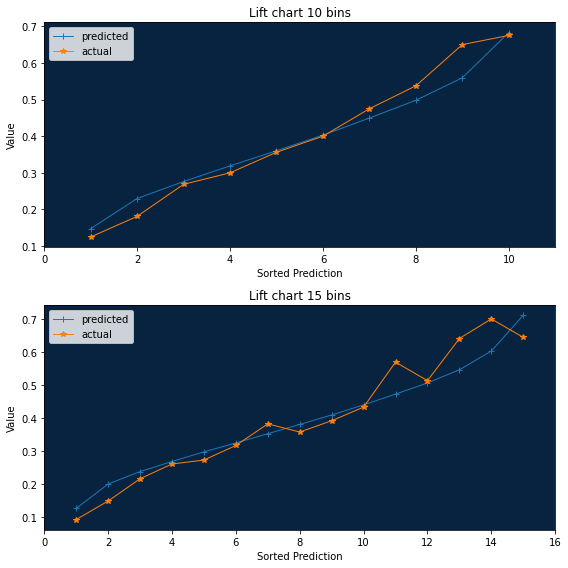

In [16]:
lift_chart = model_top.get_lift_chart('validation')

#Save the result into a pandas dataframe
lift_df = pd.DataFrame(lift_chart.bins)

bin_counts = [10, 15]
f, axarr = plt.subplots(len(bin_counts))
f.set_size_inches((8, 4 * len(bin_counts)))

rebinned_dfs = []
for i in range(len(bin_counts)):
    rebinned_dfs.append(matplotlib_lift(lift_df, bin_counts[i], axarr[i]))

plt.tight_layout()
# plt.show()


### ROC Curve

The receiver operating characteristic curve, or [ROC curve](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/roc-curve-tab/roc-curve.html), is a graphical plot that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.

In [17]:
roc = model_top.get_roc_curve('validation')

#Save the result into a pandas dataframe
roc_df = pd.DataFrame(roc.roc_points)

roc_df


,accuracy,f1_score,false_negative_score,true_negative_score,true_positive_score,false_positive_score,true_negative_rate,false_positive_rate,true_positive_rate,matthews_correlation_coefficient,positive_predictive_value,negative_predictive_value,threshold,fraction_predicted_as_positive,fraction_predicted_as_negative,lift_positive,lift_negative
0,0.603125,0.000000,635,965,0,0,1.000000,0.000000,0.000000,0.000000,0.000000,0.603125,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.603750,0.003145,634,965,1,0,1.000000,0.000000,0.001575,0.030829,1.000000,0.603502,0.878030,0.000625,0.999375,2.519685,1.000625
2,0.605625,0.012520,631,965,4,0,1.000000,0.000000,0.006299,0.061715,1.000000,0.604637,0.849079,0.002500,0.997500,2.519685,1.002506
3,0.606875,0.021773,628,964,7,1,0.998964,0.001036,0.011024,0.069276,0.875000,0.605528,0.788308,0.005000,0.995000,2.204724,1.003984
4,0.608125,0.036866,623,961,12,4,0.995855,0.004145,0.018898,0.072540,0.750000,0.606692,0.764327,0.010000,0.990000,1.889764,1.005914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.415625,0.575579,1,31,634,934,0.032124,0.967876,0.998425,0.106760,0.404337,0.968750,0.107994,0.980000,0.020000,1.018801,1.606218
115,0.408750,0.573105,0,19,635,946,0.019689,0.980311,1.000000,0.088927,0.401645,1.000000,0.090816,0.988125,0.011875,1.012018,1.658031
116,0.406875,0.572330,0,16,635,949,0.016580,0.983420,1.000000,0.081528,0.400884,1.000000,0.083076,0.990000,0.010000,1.010101,1.658031
117,0.397500,0.568487,0,1,635,964,0.001036,0.998964,1.000000,0.020286,0.397123,1.000000,0.043779,0.999375,0.000625,1.000625,1.658031


### Feature Impact

[Feature Impact](https://docs.datarobot.com/en/docs/modeling/analyze-models/understand/feature-impact.html) measures how important a feature is in the context of its predictive power for a model. It measures how much the accuracy of a model would decrease if that feature was removed.

Feature Impact is available for all model types and works by altering input data and observing the effect on a model’s score. It is an on-demand feature, meaning that you must initiate a calculation to see the results. Once DataRobot computes the feature impact for a model, that information is saved with the project.

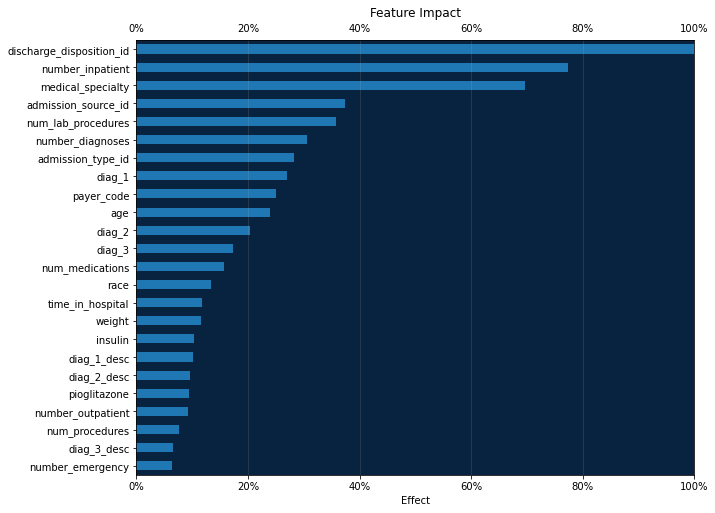

In [18]:
feature_impacts = model_top.get_or_request_feature_impact()

# Limit size to make chart look good. Display top 25 values
if len(feature_impacts) > 25:
    feature_impacts = feature_impacts[0:24]
    
# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by='impactNormalized', ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0
                                              else dr_blue)

ax = impact_df.plot.barh(x='featureName', y='impactNormalized',
                         legend=False,
                         color=bar_colors,
                         figsize=(10, 8))
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel('')
plt.xlabel('Effect')
plt.xlim((None, 1))  # Allow for negative impact
plt.title('Feature Impact', y=1.04);

## Make predictions

### Test predictions

After determining the top-performing model from the Leaderboard, upload the prediction test dataset to verify that the model generates predictions successfully before deploying the model to a production environment. This is just for testing purposes, as the code uses the modeling workers (which you do not want to do outside of quick tests). The predictions are returned as a Pandas dataframe. 

In [22]:
data_path_scoring = "https://s3.amazonaws.com/datarobot-use-case-datasets/10kDiabetesScoring.csv"
scoring_df = pd.read_csv(data_path_scoring)

prediction_dataset = project.upload_dataset(scoring_df)
predict_job = model_top.request_predictions(prediction_dataset.id)
prediction_dataset.id

predictions = predict_job.get_result_when_complete()
pd.concat([scoring_df, predictions], axis=1)

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,diabetesMed,diag_1_desc,diag_2_desc,diag_3_desc,row_id,prediction,positive_probability,prediction_threshold,class_0.0,class_1.0
0,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,Surgery-Neuro,...,No,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified",0,0.0,0.204774,0.5,0.795226,0.204774
1,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,?,...,No,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia,1,0.0,0.253130,0.5,0.746870,0.253130
2,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,Family/GeneralPractice,...,Yes,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia,2,0.0,0.458343,0.5,0.541657,0.458343
3,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,?,...,Yes,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...,3,0.0,0.200287,0.5,0.799713,0.200287
4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,Psychiatry,...,Yes,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis,4,0.0,0.286513,0.5,0.713487,0.286513
5,Caucasian,Male,[70-80),?,Elective,Discharged to home,Physician Referral,4,?,Cardiology,...,Yes,"Congestive heart failure, unspecified",Paroxysmal supraventricular tachycardia,Coronary atherosclerosis of unspecified type o...,5,0.0,0.385676,0.5,0.614324,0.385676
6,Caucasian,Female,[60-70),?,Elective,Expired,Physician Referral,6,MC,InternalMedicine,...,Yes,Cerebral thrombosis without mention of cerebra...,"Generalized nonconvulsive epilepsy, without me...",Acute kidney failure,6,0.0,0.081566,0.5,0.918434,0.081566
7,Caucasian,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,2,?,?,...,Yes,Other and unspecified noninfectious gastroente...,Diverticulosis of small intestine (without men...,Internal hemorrhoids without mention of compli...,7,1.0,0.608534,0.5,0.391466,0.608534
8,Caucasian,Male,[50-60),?,NaN,Discharged to home,NaN,3,?,Family/GeneralPractice,...,No,"Congestive heart failure, unspecified",Endomyocardial fibrosis,Viral hepatitis A with hepatic coma,8,1.0,0.566809,0.5,0.433191,0.566809
9,Caucasian,Male,[60-70),?,Elective,Discharged to home,Physician Referral,5,?,Surgery-Cardiovascular/Thoracic,...,Yes,Atherosclerosis of aorta,"Postoperative shock, unspecified","Postoperative shock, unspecified",9,0.0,0.246936,0.5,0.753064,0.246936


### Deploy a model to production


If you are happy with the model's performance, you can deploy it to a production environment with [MLOps](https://docs.datarobot.com/en/mlops/index.html).  Deploying the model will free up workers, as data scored through the deployment doesn't use any modeling workers. Furthermore, you are no longer restricted on the amount of data to score; score over 100GB with the deployment. Deployments also offer many model management benefits: monitoring service, data drift, model comparison, retraining, and more.

In [33]:
# Create a prediction server
prediction_server = dr.PredictionServer.list()[0]

# Get top performing model. Uncomment if this did not execute in the previous section
# model_top = sorted_by_metric(models, 'crossValidation', metric)[0]

deployment = dr.Deployment.create_from_learning_model(
    model_top.id, label='Hospital Readmission', description='Hospital Readmission',
    default_prediction_server_id=prediction_server.id)
deployment


Deployment(Late Shipment Predictions)

### Configure batch predictions

After the model has been deployed, DataRobot creates an endpoint for real time scoring. The deployment allows you to use DataRobot's batch prediction API to score large datasets with a deployed DataRobot model. 

The batch prediction API provides flexible intake and output options when scoring large datasets using prediction servers. The API is exposed through the DataRobot Public API and can be consumed using a REST-enabled client or Public API bindings for DataRobot's Python client.

#### Set the deployment ID

Before proceeding, provide the deployed model's deployment ID (retrieved from the deployment's [Overview tab](https://docs.datarobot.com/en/docs/mlops/monitor/dep-overview.html)).

In [ ]:
deployment_id = "YOUR_DEPLOYMENT_ID"

#### Determine input and output options

DataRobot's batch prediction API allows you to score data from and to multiple sources. You can take advantage of the credentials and data sources you have already established previously through the UI for easy scoring. Credentials are usernames and passwords, while data sources are any databases with which you have previously established a connection (e.g., Snowflake). View the example code below outlining how to query credentials and data sources.

You can reference the full list of DataRobot's supported [input](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/intake-options.html) and [output options](https://docs.datarobot.com/en/docs/predictions/batch/batch-prediction-api/output-options.html).

The snippet below shows how you can query all credentials tied to a DataRobot account.

In [ ]:
dr.Credential.list()

The output above returns multiple sets of credentials. The alphanumeric string included in each item of the list is the credentials ID. You can use that ID to access credentials through the API.

The snippet below shows how you can query all data sources tied to a DataRobot account. The second line lists each datastore with an alphanumeric string; that is the datastore ID.

In [6]:
dr.DataStore.list()
print(dr.DataStore.list()[0].id)

5e6696ff820e737a5bd78430


### Scoring examples

The snippets below demonstrate how to score data with the Batch Prediction API. Edit the `intake_settings` and `output_settings` to suit your needs. You can mix and match until you get the outcome you prefer.

#### Score from CSV to CSV

In [ ]:
# Scoring without Prediction Explanations
dr.BatchPredictionJob.score(
    deployment_id,
    intake_settings={
        'type': 'localFile',
        'file': 'inputfile.csv' # Provide the filepath, Pandas dataframe, or file-like object here
    },
    output_settings={
        'type': 'localFile',
        'path': 'outputfile.csv'
    }
)

#Scoring with Prediction Explanations
dr.BatchPredictionJob.score(
    deployment_id,
    intake_settings={
        'type': 'localFile',
        'file': 'inputfile.csv' # Provide the filepath, Pandas dataframe, or file-like object here
    },
    output_settings={
        'type': 'localFile',
        'path': 'outputfile.csv'
    },
    
    max_explanations=3 #Compute Prediction Explanations for the amount of features indicated here
    
)

#### Score from S3 to S3

In [ ]:
dr.BatchPredictionJob.score(
    deployment_id,
    intake_settings={
        'type': 's3',
        'url': 's3://theos-test-bucket/lending_club_scoring.csv', #Provide the URL of your datastore here
        'credential_id': 'YOUR_CREDENTIAL_ID_FROM_ABOVE', # Provide your credentials here
    },
    output_settings={
        'type': 's3',
        'url': 's3://theos-test-bucket/lending_club_scored2.csv',
        'credential_id': 'YOUR_CREDENTIAL_ID_FROM_ABOVE'
    }
)

#### Score from JDBC to JDBC

In [ ]:
dr.BatchPredictionJob.score(
    deployment_id,
    
    intake_settings = {
    'type': 'jdbc',
    'table': 'table_name',
    'schema': 'public',
    'dataStoreId': data_store.id, #Provide the ID of your datastore here
    'credentialId': cred.credential_id # Provide your credentials here
    },
    
    output_settings = {
        'type': 'jdbc',
        'table': 'table_name',
        'schema': 'public',
        'statementType': 'insert',
        'dataStoreId': data_store.id,
        'credentialId': cred.credential_id
    }
)